# Exploring the XBT dataset

This notebook explores the XBT dataset and considers how the distribution of the arious metadata fields may present challenges in using machine learning to fill in unknown metadata. In particular we are interested in the *instrument* field in the raw data, which is split into *model* and *manufacturer* when read in by the XbtDataset class, and the distribution of observations into  different categories of model and manufacturer. This is important information to know when setting up Machine Learning algorithms to be applied to this data. In cases where the distribution of classes of the target or input attributes are unbalanced (i.e. there are many more datapoints in one class compared to the other classes), we need to be careful how the training/dev/test data subsets are constructed to ensure that the classification performance metrics we use to evaulate the performance of the algorithms gives meaningful and useful results.


<img src='https://upload.wikimedia.org/wikipedia/commons/e/ee/Launching-an-expendable-bathythermograph-XBT.jpg' style="height:300px">

In [1]:
import os
import sys
import functools
import pathlib
import importlib

In [2]:
import matplotlib
import matplotlib.pyplot
import cartopy.crs as ccrs
import ipywidgets
import numpy
import pandas

In [3]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [4]:
from xbt.dataset import XbtDataset
import xbt.dataset

In [5]:
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'


In [6]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

In [7]:
input_data_dir_name = 'csv_with_imeta'
plot_dir_name = 'plots'

In [8]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
xbt_input_dir = os.path.join(root_data_dir, input_data_dir_name)
year_range=env_date_ranges[environment]
xbt_plots_dir = os.path.join(root_data_dir, plot_dir_name)

# Geographic location of observations
An important aspect of the metadata is the correlation between geographic location and the model/manufacturer of the probe. This interactive plot allows one to plot where observations from a particular time period are located, for all types or for particular types. Country code of the observations was used as a discriminator in the deterministic iMeta algorithm which is currently used to determine model and manufacturer for profiles where this metadata is missing.

In [9]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 1min 36s, sys: 13.4 s, total: 1min 50s
Wall time: 5min 58s


In [10]:
def plot_obs_density(year):
    figure_name = f'xbt_profile_density'
    fig_prof_dens = matplotlib.pyplot.figure(figure_name, figsize=(16,16))
    projection1 = ccrs.PlateCarree()
    axes_prof_dens = fig_prof_dens.add_subplot(111, projection=projection1)
    axes_prof_dens.coastlines()

    _ = axes_prof_dens.hist2d(xbt_full_dataset.filter_obs({'year': year}).xbt_df.lon, 
                              xbt_full_dataset.filter_obs({'year': year}).xbt_df.lat, 
                              bins=(100,50), range=((-180.0, 180.0), (-90.0, 90.0)), cmap='GnBu')
    axes_prof_dens.set_xlim((-180.0,180.0))
    axes_prof_dens.set_ylim((-90.0,90.0))
    axes_prof_dens.set_xticks([-180, -120, -60.0, 0, 60, 120, 180], crs=projection1)
    _ = axes_prof_dens.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection1)


In [11]:
prof_dens_widget = ipywidgets.interact(plot_obs_density, year=year_range)

interactive(children=(IntSlider(value=1990, description='year', max=2015, min=1966), Output()), _dom_classes=(…

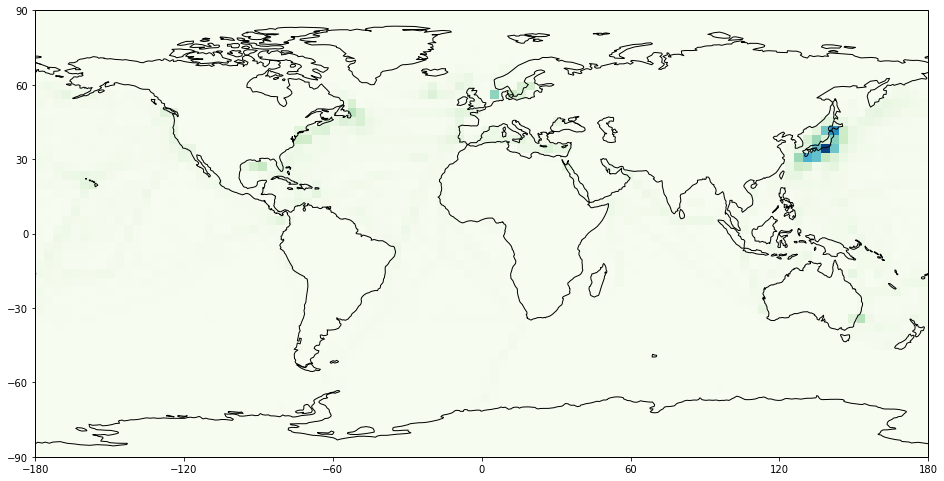

In [12]:
plot_obs_density(1991)

In [13]:
parent_widget = None
def do_plot(year, instrument, show_unknown):
    figure_name = f'xbt_data_plot'
    xbt_year = xbt_full_dataset.filter_obs({'year': year})
    if parent_widget:
        parent_widget.widget.children[1].options = xbt_year.instruments + ['all']
    current_figure = matplotlib.pyplot.figure(figure_name, figsize=(16,16))
    projection1 = ccrs.PlateCarree()
    current_axes = current_figure.add_subplot(111, projection=projection1)
    current_axes.coastlines()
    xbt_subset = xbt_year.filter_obs({'labelled': show_unknown})
    if instrument == 'all':
        data_subset_df = xbt_subset.xbt_df
    else:
        data_subset_df = xbt_subset.filter_obs({'instrument': instrument}).xbt_df
    current_axes.plot(numpy.array( data_subset_df.lon), numpy.array(data_subset_df.lat), 'r+')
    current_axes.set_title(f'XBT {year} instrument={instrument}')
    current_axes.set_xlim((-180.0,180.0))
    current_axes.set_ylim((-90.0,90.0))
    current_axes.set_xticks([-180, -120, -60.0, 0, 60, 120, 180], crs=projection1)
    current_axes.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection1)


In [14]:
instr_list = xbt_full_dataset.instruments + ['all']
parent_widget = ipywidgets.interact(do_plot, year=year_range, instrument=instr_list, show_unknown=['all','labelled','unlabelled'])

interactive(children=(IntSlider(value=1990, description='year', max=2015, min=1966), Dropdown(description='ins…

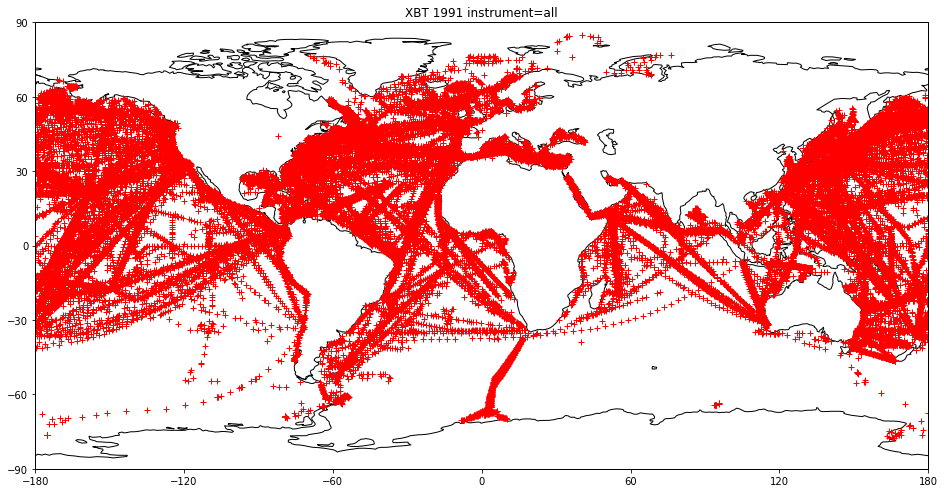

In [15]:
do_plot(1991, 'all', 'all')

# Frequency of model and manufacturer
An important consideration in applying a machine learning algorithm to this data is the distribution of class labels. A naive application of ML algorithms for classification usually assumes a reasonably even distribution among classes. The plots below show that the observations are not evenly distributed between classes. This will need to be taken into consideration when designing the experiment, especially in sampling the profiles for splitting the data into training and test sets.

The graphs show that a majority of profiles are from instruments manufactured by Sippican. The next largest manufacturer is TSK. For both manufacturers, T4 is the most common model of probe. The fact that a few probe model and manufacturers represent most profiles is why a deterministic algorithm like iMeta which linearly separates based on a few variables can infer probe model and manufacturer with reasonably high accuracy. A ML approach can improve on these results by learning when a profile is likely to be from an instrument of a less common model or manufacturer.

In [ ]:
num_to_plot = 20

In [ ]:
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

In [ ]:
class_to_plot = 8
fig_instr_freq_pie = matplotlib.pyplot.figure('instrument_freqs', figsize=(12,12))
ax_instr_freq_pie = fig_instr_freq_pie.add_subplot(1,1,1, title='Frequncies of different instrument types (for known types)')
pandas.DataFrame({'instrument': xbt_labelled.xbt_df.instrument.value_counts().index[:class_to_plot],
                  'instrument frequency': xbt_labelled.xbt_df.instrument.value_counts().values[:class_to_plot],
                 },index=xbt_labelled.xbt_df.instrument.value_counts().index[:class_to_plot]).plot.pie(ax=ax_instr_freq_pie, y='instrument frequency')
fig_instr_freq_pie.savefig(os.path.join(xbt_plots_dir, 'xbt_instr_freqs.png'), bbox_inches='tight')


In [ ]:
fig_name = 'xbt_plot_model_manu'
fig1 = matplotlib.pyplot.figure(fig_name,figsize=(20,10))
axis_country = fig1.add_subplot(121)
axis_country.set_title('Model class distribution - log scale')
xbt_labelled.xbt_df['model'].value_counts()[:num_to_plot].plot(kind='bar',ax=axis_country, figsize=(20,7),logy=True )
axis_inst = fig1.add_subplot(122)
axis_inst.set_title('Manufacturer class distribution')
xbt_labelled.xbt_df['manufacturer'].value_counts()[:num_to_plot].plot(kind='bar',ax=axis_inst,figsize=(20,7))
fig1.savefig('model_and_manu_distribution.png')

In [ ]:
top_manufacturers = xbt_labelled.xbt_df['manufacturer'].value_counts().index


In [ ]:
fig_name = 'xbt_plot_models_by_manfacturer'
fig1 = matplotlib.pyplot.figure(fig_name)

axis_manu0 = fig1.add_subplot(121)
axis_manu0.set_title(f'Model class distribution for {top_manufacturers[0]}')
xbt_full_dataset.filter_obs({'manufacturer':top_manufacturers[0]}).xbt_df['model'].value_counts().plot(kind='bar',ax=axis_manu0,figsize=(20,5))

axis_manu1 = fig1.add_subplot(122)
axis_manu1.set_title(f'Model class distribution for {top_manufacturers[1]}')
xbt_labelled.filter_obs({'manufacturer':top_manufacturers[1]})['model'].value_counts().plot(kind='bar',ax=axis_manu1,figsize=(20,5))
fig1.savefig(os.path.join(xbt_plots_dir, 'top_manufacturers_model_distribution.png'))


## Frequency of other metadata

We also want to understand how other metadata such as country and platform are distributed. Information about correlations between different metadata fields will be investiagted in a later section. The country code is used in the iMeta algorithm and so is expected to be an important discriminating feature. The institute, platform and other such information does not obviously show potential for separating probe types, but there may be connections we cannot spot easily in such plots that ML algorithms may be able to find.

In [ ]:
fig_name = 'xbt_country_and_inst'
fig1 = matplotlib.pyplot.figure(fig_name)
axis_country = fig1.add_subplot(121)
axis_country.set_title('Country distribution - log scale')
xbt_labelled['country'].value_counts()[:num_to_plot].plot(kind='bar',ax=axis_country,figsize=(20,10), logy=True )
axis_inst = fig1.add_subplot(122)
axis_inst.set_title('Institute distribution - log scale')
xbt_labelled['institute'].apply(lambda s1:s1[:20]).value_counts()[:num_to_plot].plot(kind='bar',ax=axis_inst,figsize=(20,5), logy=True)
fig1.savefig(os.path.join(xbt_plots_dir, 'xbt_country_and_inst_distributions.png'))

### Plot obs per year

The plots below show distribution of profiles by year. The blue parts of the bars show the number of profiles for each year where we have the probe model or probe manufacturer. The red parts of the bars show for how many profiles in a given year that information is missing. We can see that throughout the dataset the number of profiles where  model information is missing is relatively low. For manufacturer, the number of profiles  with missing information is mostly low, but we can see that around the mid-1990's there is a much higher proportion with this metadata missing, though still a fairly low proportion. Improvements to classification through use of machine learning algorithms are thus most likely to have a substantial impact on ocean temperature and ocean heat content datasets if they can substantially improve the accuracy of classification for the subset of year where there is a lot of missing data. 

In [ ]:
unknown_manufacturer_by_year = []
known_manufacturer_by_year = []
unknown_model_by_year = []
known_model_by_year = []
for year in range(*year_range):
    xbt_ds1 = xbt_full_dataset.filter_obs({'year': year})
    unknown_manufacturer_by_year += [xbt_ds1.num_unknown_manufacturer]
    known_manufacturer_by_year += [xbt_ds1.known_manufacturer_dataset.shape[0]]
    unknown_model_by_year += [xbt_ds1.num_unknown_model]
    known_model_by_year += [xbt_ds1.known_model_dataset.shape[0]]    

In [ ]:
figure_name = f'xbt_unknown_manufacturer'
current_figure = matplotlib.pyplot.figure(figure_name, figsize=(24,12))
current_axes = current_figure.add_subplot(121)
current_axes.bar(range(*year_range), known_manufacturer_by_year, color='b')
current_axes.bar(range(*year_range), unknown_manufacturer_by_year, bottom=known_manufacturer_by_year, color='r')
current_axes.set_title('num observations with manufacturer label per year')
current_axes = current_figure.add_subplot(122)
current_axes.bar(range(*year_range), known_model_by_year, color='b')
current_axes.bar(range(*year_range), unknown_model_by_year, bottom=known_model_by_year, color='r')
current_axes.set_title('num observations with model label per year')
current_figure.savefig(os.path.join(xbt_plots_dir, 'xbt_plot_obs_with_unknown_type_by_year.png'))

In [ ]:

fig_instr_labelled = matplotlib.pyplot.figure('instrument_labelled', figsize=(8,8))
ax_instr_laelled = fig_instr_labelled.add_subplot(1,1,1, title='Number of labelled vs unlabelled profiles (for instrument type metadata)')

pandas.merge(
    pandas.DataFrame({'year': xbt_full_dataset.filter_obs({'labelled': 'labelled'}).xbt_df.year.value_counts(sort=False).index,
                      'labelled': xbt_full_dataset.filter_obs({'labelled': 'labelled'}).xbt_df.year.value_counts(sort=False).values
                     }),
    pandas.DataFrame({'year': xbt_full_dataset.filter_obs({'labelled': 'unlabelled'}).xbt_df.year.value_counts(sort=False).index,
                      'unlabelled': xbt_full_dataset.filter_obs({'labelled': 'unlabelled'}).xbt_df.year.value_counts(sort=False).values
                     }),
    on='year'
).plot.area(stacked=True,
           x='year', 
           color=['b','r'], 
           ax=ax_instr_laelled,
           xticks=list(range(1965,2020,5)),
          )
fig_instr_labelled.savefig(os.path.join(xbt_plots_dir, 'xbt_instr_num_labelled.png'),
                          bbox_inches='tight')
    

We can see that there are very small numbers of missing model fields for any of the years in the dataset. For most years, there are also very few observations with missing manufacturer metadata, but there are some year in the 1980s and 1990s with a more substantial number of observations with missing manufacturer information, up to 20% in a few years.

## Missing model/manufacturer per cruise

We also interested in what percentage of cruises in a given year have complete metadata information for model & manufacturer compared to how many cruises there are where 1 or more observation is missing the model or manufacturer metadata.

We want to know information about those cruises where some of the observations are missing metadata. In particular, do cruises with such observations have other observations where the metadata is present? Do such cruises have all observations from the same probetypes, or do they have multiple prove types?

In [ ]:
year

In [ ]:
unknown_model_years = []
unknown_manufacturer_years = []
num_cruises = []
num_all_known_model = []
num_all_known_manufacturer = []
num_no_model_years = []
num_no_manufacturer_years = []
for year in range(*year_range):
    cs, nu_model, no_model, nu_manufacturer, no_manu = xbt_full_dataset.filter_obs({'year': year}).get_cruise_stats()
    num_cruises += [len(cs)]
    unknown_model_years += [nu_model]
    num_no_model_years += [no_model]
    num_all_known_model += [len(cs) - nu_model]
    unknown_manufacturer_years += [nu_manufacturer]
    num_all_known_manufacturer += [len(cs) - nu_manufacturer]
    num_no_manufacturer_years += [no_manu]


In [ ]:
figure_name = f'xbt_cruises_unknowns'
current_figure = matplotlib.pyplot.figure(figure_name, figsize=(24,12))
current_axes = current_figure.add_subplot(121)
current_axes.bar(range(*year_range), num_all_known_model, color='b')
current_axes.bar(range(*year_range), unknown_model_years, bottom=num_all_known_model, color='r')
current_axes.set_title('num cruises per year with no or some observations with unknown models')
current_axes = current_figure.add_subplot(122)
current_axes.bar(range(*year_range), num_all_known_manufacturer, color='b')
current_axes.bar(range(*year_range), unknown_manufacturer_years, bottom=num_all_known_manufacturer, color='r')
current_axes.set_title('num cruises per year with no or some observations with unknown manufacturers')
current_figure.savefig(os.path.join(xbt_plots_dir,'xbt_plot_cruises_with_unknown_model_or_manu.png'))

In [ ]:
figure_name = f'xbt_cruises_no_data'
current_figure = matplotlib.pyplot.figure(figure_name, figsize=(24,12))
current_axes = current_figure.add_subplot(121)
current_axes.bar(range(*year_range), num_no_model_years, color='r')
current_axes.set_title('num cruises per year with missing model for all observations')

current_axes = current_figure.add_subplot(122)
current_axes.bar(range(*year_range), num_no_manufacturer_years, color='r')
current_axes.set_title('num cruises per year with missing manufacturer for all observations')
current_figure.savefig(os.path.join(xbt_plots_dir, figure_name + '.png'))

In [ ]:
xbt_full_dataset.num_obs

## Data exploration conclusions

The purpose of this data exploration notebook is to establish the properties of the dataset to inform how we approach the creation of the machine learning experiment pipeline. The following relevant points need to be taken into consideration:

* The datasetapproximately 2.2 million profiles  from WOD, 1.1 million are labelled and 1.1 million are unlabelled. 
 * The labelled data will be used to train and evaluate the machine learning algorithms. 
 * Predicting instrument type for the unlabelled data is point of the project.
* instrument type class are unbalanced in membership. More than 75% of all labelled data belongs to three classes. This will need to be considered in splitting data.
 * We sure should an even split by instrument into train and test sets.
* the cruise number, institute etc. contain many (1000s) classes with only a few profiles per class. This makes this impractical for naive one hot encoding. Also each platform or cruise comes from a single country, so country plus lat/lon will be used as proxy.
* In the unlabelled data, we two sorts of profiles in terms of the relationship with labelled profiled:
 * some of the unlabelled profiles come from cruises where other profiles in the same cruise do have instrument type labels. This is important as profiles from each cruise tend to all come from the same 1 or 2 instrument types.
 * some of the unlabelled data comes from cruises where none of the other profiles are labelled. In this case we can not come up with a likely instrument type based on other profiles in the cruise.
 * we want to check in our evaluation that the trained algorithm generalises well to both sorts of unlabelled data. To this end we should select some cruises at the start and set aside all profiles from those cruises to not be used at all in training, hyperparameter tuning or other development tasks, and use these profile right at the end to evaluate the performance of different algorithms.
 